# Working with MOD13 Vegetation Indices data

I assume this process is going to be similar to burned data 

In [1]:
# Import libraries
import os
import glob
from osgeo import gdal
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import scipy.ndimage
import pandas as pd
import datetime as dt
import rasterio as rio
import re
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em
from pyhdf.SD import SD, SDC
import matplotlib.colors as colors 
from mpl_toolkits.axes_grid1 import make_axes_locatable 

In [24]:
# Set input directory, and change working directory
inDir = "D:\\masters_data"   # I should change this so I can work from github?
os.chdir(inDir)                                                               # Change to working directory
outDir = os.path.normpath(os.path.split(inDir)[0] + os.sep + 'output') + '\\' # Create and set output directory
if not os.path.exists(outDir): os.makedirs(outDir)

In [26]:
#select all MOD13A3 files in my folder - also removes all other formats (.XML etc. - not sure if these files have value)
MODISFiles = glob.glob('MOD13A1*h20v07*.hdf') 
MODISFiles

['MOD13A1.A2009081.h20v07.006.2015188085636.hdf',
 'MOD13A1.A2009097.h20v07.006.2015189152957.hdf',
 'MOD13A1.A2009113.h20v07.006.2015189143500.hdf',
 'MOD13A1.A2009129.h20v07.006.2015189211850.hdf',
 'MOD13A1.A2009145.h20v07.006.2015190115732.hdf',
 'MOD13A1.A2009161.h20v07.006.2015190220023.hdf',
 'MOD13A1.A2009177.h20v07.006.2015191092653.hdf',
 'MOD13A1.A2009193.h20v07.006.2015192135834.hdf',
 'MOD13A1.A2009209.h20v07.006.2015192140836.hdf',
 'MOD13A1.A2009225.h20v07.006.2015194150936.hdf',
 'MOD13A1.A2009241.h20v07.006.2015194150902.hdf',
 'MOD13A1.A2009257.h20v07.006.2015194225008.hdf',
 'MOD13A1.A2009273.h20v07.006.2015195130334.hdf',
 'MOD13A1.A2009289.h20v07.006.2015195223739.hdf',
 'MOD13A1.A2009305.h20v07.006.2015196131754.hdf',
 'MOD13A1.A2009321.h20v07.006.2015196201833.hdf',
 'MOD13A1.A2009337.h20v07.006.2015197065045.hdf']

In [27]:
#select one file to get its data - Soon I could create a forloop to run through all the files automatically?
print(MODISFiles[0])

MOD13A1.A2009081.h20v07.006.2015188085636.hdf


In [7]:
#Just makes clear MODIS File naming convention and changes it from Julian date (YYYYDDD)
productId = MODISFiles[0].split('.')[0]                                         # First: product name
yeardoy = MODISFiles[0].split(productId + '.A')[1].split('.')[0]                # Julian date
date = dt.datetime.strptime(yeardoy, '%Y%j').strftime('%d/%m/%Y')               # Convert YYYYDDD to DD/MM/YYYY
tiles_id = MODISFiles[0].split(yeardoy + '.')[1].split('.006')[0]               # Second: tile id
unknown_format = MODISFiles[0].split(tiles_id +'.006.')[1].split('.hdf')[0]     # Third: date (DD/MM/YYYY)


print('Product Name: {}\nLayer ID: {}\nDate of Observation: {}\n(Not sure what this represents: {})'.format(productId, tiles_id, date, unknown_format ))

Product Name: MOD13A3
Layer ID: h19v07
Date of Observation: 01/01/2015
(Not sure what this represents: 2015295114815)


Find out what last part of naming convention represents

In [8]:
# View dataset metadata at the highest level of file - Not sure if this actually tells me anything useful
with rio.open(MODISFiles[0]) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

hdf4_meta

<open DatasetReader name='MOD13A3.A2015001.h19v07.006.2015295114815.hdf' mode='r'>


C:\Users\samgr\miniconda3\envs\GDAL_test\lib\site-packages\rasterio\__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [9]:
# Print all of the subdatasets in the file - I think NDVI and EVI are the ones I'm interested in
with rio.open(MODISFiles[0]) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly NDVI
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly relative azimuth angle
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly pixel reliability
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly EVI
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly VI Quality
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly red reflectance
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly NIR reflectance
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1km_VI:1 km monthly blue reflectance
HDF4_EOS:EOS_GRID:MOD13A3.A2015001.h19v07.006.2015295114815.hdf:MOD_Grid_monthly_1

In [10]:
file_name = 'MOD13A3.A2015001.h19v07.006.2015295114815.hdf'
file = SD(file_name, SDC.READ)  # SDC means scientific dataset  

print( file.info() )  # means there is 11 scientific datasets, although im not sure what the 6 signifies

(11, 6)


In [11]:
# print datasets in file
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print(idx,sds)

0 1 km monthly NDVI
1 1 km monthly EVI
2 1 km monthly VI Quality
3 1 km monthly red reflectance
4 1 km monthly NIR reflectance
5 1 km monthly blue reflectance
6 1 km monthly MIR reflectance
7 1 km monthly view zenith angle
8 1 km monthly sun zenith angle
9 1 km monthly relative azimuth angle
10 1 km monthly pixel reliability


In [12]:
# get data for NDVI - can change this to get data for EVI or other simply by changing the index number
sds_obj = file.select(0) # select sds

data = sds_obj.get() # get sds data
print(data)

[[ 942  909  877 ...  938  891  931]
 [ 926  922  890 ...  850  943  931]
 [ 907  909  896 ...  963  947  955]
 ...
 [2996 3215 3117 ... 4299 4433 4270]
 [2787 3089 3035 ... 3453 3805 3320]
 [3031 2990 3132 ... 4372 4316 3319]]


In [13]:
# print attributes to see scale factor and add_offset
import pprint
pprint.pprint( sds_obj.attributes() )

{'_FillValue': -3000,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 5,
 'long_name': '1 km monthly NDVI',
 'scale_factor': 10000.0,
 'scale_factor_err': 0.0,
 'units': 'NDVI',
 'valid_range': [-2000, 10000]}


***
**The code below applies the scale factor although I am not sure this is wanted because the spreadsheet on HDFView has the value of "data" (above) not "scaled_data" (below)**
***

In [14]:
for key, value in sds_obj.attributes().items():
    print(key, value)
    if key == 'add_offset':
        add_offset = value  
    if key == 'scale_factor':
        scale_factor = value

long_name 1 km monthly NDVI
units NDVI
valid_range [-2000, 10000]
_FillValue -3000
scale_factor 10000.0
scale_factor_err 0.0
add_offset 0.0
add_offset_err 0.0
calibrated_nt 5


In [15]:
scaled_data = (data - add_offset) * scale_factor
print(scaled_data)
# I don't think that scaled_data is right - outside of valid range

[[ 9420000.  9090000.  8770000. ...  9380000.  8910000.  9310000.]
 [ 9260000.  9220000.  8900000. ...  8500000.  9430000.  9310000.]
 [ 9070000.  9090000.  8960000. ...  9630000.  9470000.  9550000.]
 ...
 [29960000. 32150000. 31170000. ... 42990000. 44330000. 42700000.]
 [27870000. 30890000. 30350000. ... 34530000. 38050000. 33200000.]
 [30310000. 29900000. 31320000. ... 43720000. 43160000. 33190000.]]


In [16]:
print(scaled_data.shape)

(1200, 1200)


In [17]:
print(data.shape)

(1200, 1200)


I now need to view this data as a picture but I am not sure how to convert it

<ipython-input-23-3ded11f6dc29>:15: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size ="5 %")


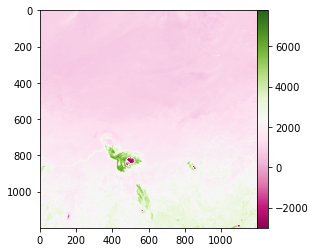

In [23]:
u = np.unique(data) 
bounds = np.concatenate(([data.min()], 
                         u[:-1]+np.diff(u)/2., 
                         [data.max()])) 
  
# norm = colors.BoundaryNorm(bounds, len(bounds)) 
# color_map1 = ['#FFFAFA', '#FFA07A', '#FF6347', '#800000'] 
# color_map = colors.ListedColormap(color_map1)  
  
    
fig, axes = plt.subplots() 
img = axes.imshow(data, cmap = "PiYG", 
                  ) 
divider = make_axes_locatable(axes) 
cax = divider.append_axes("right", size ="5 %") 
  
color_bar = plt.colorbar(img,  
                        cax = cax) 
  
# color_bar.set_ticks(bounds[:-1]+np.diff(bounds)/2.) 
# color_bar.ax.set_yticklabels(color_map1) 
# color_bar.ax.tick_params(labelsize = 10) 
  
plt.show() 